In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from scipy.optimize import minimize
from sklearn.metrics import average_precision_score


Using TensorFlow backend.


In [2]:

df = pd.read_csv('../../aparent/data/leslie_derti_apadb_features_pas_3_utr3.csv', sep='\t')

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_no_x.npz")
m, l, c, y, _ = save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y'], save_dict['s']

save_dict = np.load("../../aparent/data/leslie_derti_apadb_features_pas_3_utr3_saluki_pmirGLO_construct_dense_full.npz")
hl, hl_m = save_dict['hl'], save_dict['hl_m']

a_rich = np.zeros(m.shape)
for k in range(m.shape[1]) :
    a_rich[:, k] = df['pas_exists_' + str(k)] & df['wide_seq_ext_' + str(k)].str.slice(175 - 70, 175 - 70 + 205).str.contains("AAAAAAAAAAAAA|AAAAAAGAAAAAA|AAAAAACAAAAAA")

#Define tissue-/cell- types

cell_types = np.array(['apadb_count_kidney',
       'apadb_count_pancreas',
       'apadb_count_monocytes',
       'apadb_count_all',
       'apadb_count_pdac',
       'apadb_count_prcc',
       'apadb_count_full_blood',
       'apadb_count_hlf',
       'apadb_count_pooled',
       'leslie_count_hek293',
       'leslie_count_mcf10a_hras2',
       'leslie_count_mcf10a1',
       'leslie_count_mcf10a2',
       'leslie_count_mcf10a_hras1',
       'leslie_count_bcells1',
       'leslie_count_mcf7',
       'leslie_count_bcells2',
       'leslie_count_ovary',
       'leslie_count_breast',
       'leslie_count_brain',
       'leslie_count_skmuscle',
       'leslie_count_blcl',
       'leslie_count_hES',
       'leslie_count_testis',
       'leslie_count_hela',
       'leslie_count_ntera',
       'leslie_count_pooled',
       'leslie_count_apadb_region_hek293',
       'leslie_count_apadb_region_mcf10a_hras2',
       'leslie_count_apadb_region_mcf10a1',
       'leslie_count_apadb_region_mcf10a2',
       'leslie_count_apadb_region_mcf10a_hras1',
       'leslie_count_apadb_region_bcells1',
       'leslie_count_apadb_region_mcf7',
       'leslie_count_apadb_region_bcells2',
       'leslie_count_apadb_region_ovary',
       'leslie_count_apadb_region_breast',
       'leslie_count_apadb_region_brain',
       'leslie_count_apadb_region_skmuscle',
       'leslie_count_apadb_region_blcl',
       'leslie_count_apadb_region_hES',
       'leslie_count_apadb_region_testis',
       'leslie_count_apadb_region_hela',
       'leslie_count_apadb_region_ntera',
       'leslie_count_apadb_region_pooled',
       'derti_count_brain',
       'derti_count_kidney',
       'derti_count_liver',
       'derti_count_maqc-brain1',
       'derti_count_maqc-brain2',
       'derti_count_maqc-UHR1',
       'derti_count_maqc-UHR2',
       'derti_count_muscle',
       'derti_count_testis',
       'derti_count_pooled',
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}

#Slice celltypes

cell_type = 'leslie_count_pooled'

c = c[:, :, cell_type_dict[cell_type]]
y = y[:, :, cell_type_dict[cell_type]]

model_names = [
    'aparent-resnet',
    'aparent-resnet+hl',
    'aparent',
    'deerect-apa',
    'polyapred',
]

model_scores = [
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/aparent_theano_legacy_30_31_34_pasaligned_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_deerect_apa_native_scores.npy'),
    np.load('predictions/apa_leslie_derti_apadb_data/leslie_derti_apadb_features_pas_3_utr3_polyapred_native_scores_shifted.npy'),
]

use_saluki = [
    False,
    True,
    False,
    False,
    False,
]

print("s.shape = " + str(model_scores[0].shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("y.shape = " + str(y.shape))
print("c.shape = " + str(c.shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))
print("a_rich.shape = " + str(hl_m.shape))


s.shape = (6944, 10)
m.shape = (6944, 10)
l.shape = (6944, 10)
y.shape = (6944, 10)
c.shape = (6944, 10)

hl.shape = (6944, 10, 50, 64)
hl_m.shape = (6944, 10)
a_rich.shape = (6944, 10)


In [3]:
#Re-filter on max_n_pas

max_n_pas = 10

min_total_count = 10

m = m[:, :max_n_pas]
l = l[:, :max_n_pas]
c = c[:, :max_n_pas]
hl = hl[:, :max_n_pas]
hl_m = hl_m[:, :max_n_pas]

total_c = np.sum(c, axis=-1)
total_m = np.sum(m, axis=1)
max_l = np.max(l, axis=1)

m_cons = (np.sum(m, axis=-1) == np.sum(hl_m, axis=-1))

has_a_rich = np.sum(a_rich, axis=-1)

for model_ix in range(len(model_scores)) :
    model_scores[model_ix] = model_scores[model_ix][((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]

m = m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
l = l[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), :]
c = c[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl = hl[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]
hl_m = hl_m[((m_cons & (has_a_rich <= 0)) & (((total_c > min_total_count) & (total_m >= 2)) & ((max_l >= 50.) & (max_l < 40000.)))), ...]

pseudo_count = 0.1

y = c / np.sum(c, axis=1, keepdims=True)
y[np.isnan(y)] = 0.

y_pseudo = (c + pseudo_count) / np.sum((c + pseudo_count) * m, axis=1, keepdims=True)
y_pseudo[np.isnan(y_pseudo)] = 0.

print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))
print("s.shape = " + str(model_scores[0].shape))
print("")
print("hl.shape = " + str(hl.shape))
print("hl_m.shape = " + str(hl_m.shape))


m.shape = (5546, 10)
l.shape = (5546, 10)
c.shape = (5546, 10)
y.shape = (5546, 10)
s.shape = (5546, 10)

hl.shape = (5546, 10, 50, 64)
hl_m.shape = (5546, 10)


In [4]:
#Reduce half-life feature dims with PCA

from sklearn.decomposition import PCA

pcas = []
hl_pcas = []

for model_ix in range(hl.shape[2]) :

    flat_hl = np.array(np.reshape(hl[..., model_ix, :], (hl.shape[0] * hl.shape[1], hl.shape[3])), dtype=np.float32)
    flat_hl_m = np.array(np.reshape(hl_m, (hl.shape[0] * hl.shape[1],)), dtype=np.float32)

    pca = PCA(n_components=4).fit(flat_hl[flat_hl_m >= 1., ...])

    print("Model " + str(model_ix) + ", Fraction of variance explaned = " + str(round(np.sum(pca.explained_variance_ratio_), 3)))

    flat_hl_pca = pca.transform(flat_hl) * flat_hl_m[:, None]
    hl_pca = np.reshape(flat_hl_pca, (hl.shape[0], hl.shape[1], flat_hl_pca.shape[1]))

    print(hl_pca.shape)
    
    pcas.append(pca)
    hl_pcas.append(hl_pca)


Model 0, Fraction of variance explaned = 0.963
(5546, 10, 4)
Model 1, Fraction of variance explaned = 0.98
(5546, 10, 4)
Model 2, Fraction of variance explaned = 0.982
(5546, 10, 4)
Model 3, Fraction of variance explaned = 0.972
(5546, 10, 4)
Model 4, Fraction of variance explaned = 0.971
(5546, 10, 4)
Model 5, Fraction of variance explaned = 0.957
(5546, 10, 4)
Model 6, Fraction of variance explaned = 0.973
(5546, 10, 4)
Model 7, Fraction of variance explaned = 0.972
(5546, 10, 4)
Model 8, Fraction of variance explaned = 0.968
(5546, 10, 4)
Model 9, Fraction of variance explaned = 0.981
(5546, 10, 4)
Model 10, Fraction of variance explaned = 0.983
(5546, 10, 4)
Model 11, Fraction of variance explaned = 0.975
(5546, 10, 4)
Model 12, Fraction of variance explaned = 0.981
(5546, 10, 4)
Model 13, Fraction of variance explaned = 0.972
(5546, 10, 4)
Model 14, Fraction of variance explaned = 0.971
(5546, 10, 4)
Model 15, Fraction of variance explaned = 0.976
(5546, 10, 4)
Model 16, Fraction 

In [5]:

orig_l = np.copy(l)

#l = np.log(l * m + 1.)
l = np.log(np.cumsum(l, axis=1) * m + 1.)
#l = np.log(np.cumsum(l[:, ::-1], axis=1)[:, ::-1] * m + 1.)


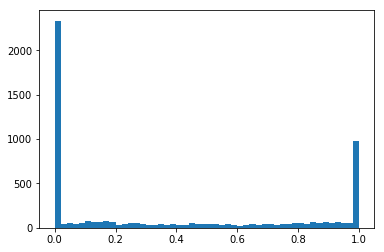

In [9]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i, dist_index[i]])

y_dist_pseudo = []
for i in range(y.shape[0]) :
    y_dist_pseudo.append(y_pseudo[i, dist_index[i]])

y_dist = np.array(y_dist)
y_dist_pseudo = np.array(y_dist_pseudo)

f = plt.figure(figsize=(6, 4))

plt.hist(y_dist, bins=50)

plt.show()


In [10]:

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.


Evaluating model = 'aparent-resnet'
fold = 0...
[ 0.85454225 -0.05254927 -5.50653292  0.99560574 -0.08027376 -4.67535554
  0.          0.        ]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.671
AP = 0.81
n = 5546


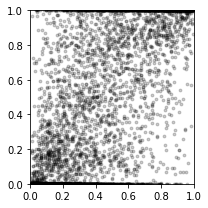

Evaluating model = 'aparent-resnet+hl'
fold = 0...
[ 0.99186809  0.01146023 -5.2455152   0.93304343 -0.03964266 -5.53623163
  0.13259236  0.252662    3.73259898 -1.06688188  0.1723267   1.33739643
  3.94544315 -1.66212989]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.709
AP = 0.84
n = 5546


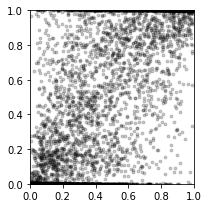

Evaluating model = 'aparent'
fold = 0...
[  0.5593246   -0.04697348  -6.24156597   0.54724972  -0.05079592
 -14.14164769   0.           0.        ]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.595
AP = 0.75
n = 5546


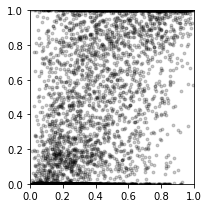

Evaluating model = 'deerect-apa'
fold = 0...
[  0.39702732  -0.06916106 -11.53114682   0.7433645    0.01699148
 -14.44242077   0.           0.        ]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.481
AP = 0.66
n = 5546


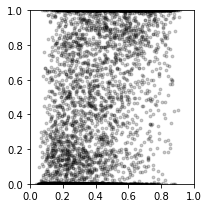

Evaluating model = 'polyapred'
fold = 0...
[  0.26443134  -0.07742694 -12.27860532   0.31696964  -0.03090257
 -24.60922314   0.           0.        ]
fold = 1...
fold = 2...
fold = 3...
fold = 4...
fold = 5...
fold = 6...
fold = 7...
fold = 8...
fold = 9...
fold = 10...
fold = 11...
fold = 12...
fold = 13...
fold = 14...
fold = 15...
fold = 16...
fold = 17...
fold = 18...
fold = 19...
Spearman r = 0.419
AP = 0.59
n = 5546


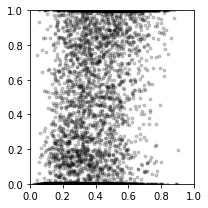

In [8]:
#Fit and evaluate regression / classification models on native measures

def logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask) :

    prox_exp = np.exp(w_prox_pas * s + np.sum(w_prox_hl[None, None, :] * hl, axis=-1) + w_prox_len * l)
    dist_exp = np.exp(w_dist_pas * s + np.sum(w_dist_hl[None, None, :] * hl, axis=-1) + w_dist_len * l)
    
    prox_score = np.sum(prox_exp * m * (1. - dist_mask), axis=1) + np.exp(w_prox_bias)
    dist_score = np.sum(dist_exp * m * dist_mask, axis=1) + np.exp(w_dist_bias)
    
    return dist_score / (dist_score + prox_score)

def logistic_model_mse(w_bundle, s, hl, m, l, dist_mask, y_true) :
    
    w_prox_pas = w_bundle[0]
    w_prox_len = w_bundle[1]
    w_prox_bias = w_bundle[2]
    w_dist_pas = w_bundle[3]
    w_dist_len = w_bundle[4]
    w_dist_bias = w_bundle[5]
    w_prox_hl = w_bundle[6:6+4] if w_bundle.shape[0] > 8 else w_bundle[6:7]
    w_dist_hl = w_bundle[6+4:6+8] if w_bundle.shape[0] > 8 else w_bundle[7:8]
    
    y_pred = logistic_model_predict(s, hl, m, l, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask)
    
    y_pred_clip = np.clip(y_pred, 1e-7, 1. - 1e-7)
    y_true_clip = np.clip(y_true, 1e-7, 1. - 1e-7)
    
    kl = y_true_clip * np.log(y_true_clip / y_pred_clip) + (1. - y_true_clip) * np.log((1. - y_true_clip) / (1. - y_pred_clip))
    
    return np.mean(kl)

from sklearn.model_selection import KFold

def cross_val_model(s, hls, m, l, dist_mask, y_true, use_saluki=False, n_folds=10) :
    
    kf = KFold(n_splits=n_folds)
    
    y_pred = np.zeros(y_true.shape)
    
    for fold_ix, [train_index, test_index] in enumerate(kf.split(s)) :
        
        print("fold = " + str(fold_ix) + "...")
        
        for hl_ix, hl in enumerate(hls) :
        
            s_train, s_test = s[train_index], s[test_index]
            hl_train, hl_test = hl[train_index], hl[test_index]
            m_train, m_test = m[train_index], m[test_index]
            l_train, l_test = l[train_index], l[test_index]
            dist_mask_train, dist_mask_test = dist_mask[train_index], dist_mask[test_index]
            y_true_train = y_true[train_index]

            w0 = np.zeros(6 + (8 if use_saluki else 2))

            res = minimize(logistic_model_mse, w0, args=(s_train, hl_train if use_saluki else 0., m_train, l_train, dist_mask_train, y_true_train), method='BFGS', options={'disp': False})

            w_prox_pas = res.x[0]
            w_prox_len = res.x[1]
            w_prox_bias = res.x[2]
            w_dist_pas = res.x[3]
            w_dist_len = res.x[4]
            w_dist_bias = res.x[5]
            w_prox_hl = res.x[6:6+4] if use_saluki else res.x[6:7]
            w_dist_hl = res.x[6+4:6+8] if use_saluki else res.x[7:8]

            if fold_ix == 0 and hl_ix == 0 :
                print(res.x)

            y_pred[test_index] += logistic_model_predict(s_test, hl_test if use_saluki else 0., m_test, l_test, w_prox_pas, w_prox_hl, w_prox_len, w_prox_bias, w_dist_pas, w_dist_hl, w_dist_len, w_dist_bias, dist_mask_test)

            if not use_saluki :
                break
            
        if use_saluki :
            y_pred[test_index] /= float(len(hls))
        
    return y_pred

model_spearman_rs = np.zeros(len(model_scores))
model_aps = np.zeros(len(model_scores))
model_y_dist_preds = np.zeros((y_dist.shape[0], len(model_scores)))

for model_ix in range(len(model_scores)) :
    
    print("Evaluating model = '" + model_names[model_ix] + "'")
    
    s = model_scores[model_ix]
    
    y_dist_pred = cross_val_model(s, hl_pcas, m, l, dist_mask, y_dist, use_saluki=use_saluki[model_ix], n_folds=20)
    
    spearman_r_val, _ = spearmanr(y_dist_pred, y_dist)
    model_spearman_rs[model_ix] = spearman_r_val
    
    y_labels = np.array([1. if y_dist[i] >= 0.5 else 0. for i in range(y_dist.shape[0])])
    
    ap = average_precision_score(y_labels, y_dist_pred)
    model_aps[model_ix] = ap
    model_y_dist_preds[:, model_ix] = y_dist_pred[:]

    print("Spearman r = " + str(round(spearman_r_val, 3)))
    print("AP = " + str(round(ap, 2)))
    print("n = " + str(y_dist.shape[0]))

    f = plt.figure(figsize=(3, 3))

    plt.scatter(y_dist_pred, y_dist, color='black', s=8, alpha=0.2)

    plt.xlim(0., 1.)
    plt.ylim(0., 1.)

    plt.tight_layout()
    plt.show()


In [9]:
#Save metrics

np.save("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_spearman_rs", model_spearman_rs)
np.save("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_aps", model_aps)
np.save("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_y_dist_preds", model_y_dist_preds)
np.save("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_orig_l", orig_l)
np.save("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_hl", hl)
np.save("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_y_dist", y_dist)
np.save("native_apa_multi_leslie_w_saluki_dense_all_folds_cv_20_y_dist_pseudo", y_dist_pseudo)
